#### 실험적으로 가중치 직접 조정

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
# 데이터 로드
data = pd.read_csv('./000660.csv')

# 데이터 칼럼명 변경
data = data.rename(
    columns={
        '시가': 'Open',
        '고가': 'High',
        '저가': 'Low',
        '종가': 'Close',
        '거래량': 'Total_Volume',
        '매도량': 'Sell_Volume',
        '매수량': 'Buy_Volume'
    })

In [27]:
# 결측치 제거
data = data.dropna()

In [28]:
# 특성 선택
# 가격 관련
price_features = ['Open', 'High', 'Low', 'Close']
# 거래량 관련
volume_features = ['Buy_Volume', 'Sell_Volume', 'Total_Volume']
# 모든 특성 리스트
features = price_features + volume_features

In [29]:
# 거래량 강도 계산
data['Volume_Intensity'] = data['Buy_Volume'] - data['Sell_Volume']
data['Volume_Intensity_Ratio'] = data['Volume_Intensity'] / (data['Total_Volume'] + 1e-5)  # 0으로 나누는 것 방지
data['Buy_Sell_Ratio'] = data['Buy_Volume'] / (data['Sell_Volume'] + 1e-5)

# 새로운 특성들을 특성 리스트에 추가
features.extend(['Volume_Intensity', 'Volume_Intensity_Ratio', 'Buy_Sell_Ratio'])

In [30]:
# 스케일러 딕셔너리 생성
scalers = {}

In [31]:
# 가격 관련 특성 스케일링
for feature in price_features:
    scaler = StandardScaler()
    data[feature] = scaler.fit_transform(data[[feature]])
    scalers[feature] = scaler

In [32]:
# 거래량 관련 특성 스케일링
for feature in volume_features + ['Volume_Intensity', 'Volume_Intensity_Ratio', 'Buy_Sell_Ratio']:
    scaler = RobustScaler()
    data[feature] = scaler.fit_transform(data[[feature]])
    scalers[feature] = scaler

In [33]:
# 가격 급변 레이블링
price_threshold = 0.005  # 0.5 이상 변동 시 급변으로 간주

data['Price_Change'] = data['Close'].pct_change()
data = data.dropna()  # 첫 번째 행 제거

def label_price_change(change):
    if change >= price_threshold:
        return 2  # 상승 급변
    elif change <= -price_threshold:
        return 0  # 하락 급변
    else:
        return 1  # 보합

data['Price_Label'] = data['Price_Change'].apply(label_price_change)

In [34]:
# 거래량 강도 급변 레이블링
intensity_threshold = data['Volume_Intensity'].std() * 2  # 표준편차의 2배를 기준으로 설정

def label_intensity(intensity):
    if intensity >= intensity_threshold:
        return 1  # 강한 매수세
    elif intensity <= -intensity_threshold:
        return -1  # 강한 매도세
    else:
        return 0  # 중립

data['Intensity_Label'] = data['Volume_Intensity'].apply(label_intensity)

In [35]:
# 복합 레이블링
def combined_label(row):
    if row['Price_Label'] == 2 and row['Intensity_Label'] == 1:
        return 3  # 상승 급변 + 강한 매수세
    elif row['Price_Label'] == 0 and row['Intensity_Label'] == -1:
        return -3  # 하락 급변 + 강한 매도세
    else:
        return row['Price_Label']  # 기존 가격 레이블 유지

data['Combined_Label'] = data.apply(combined_label, axis=1)

In [36]:
# 레이블 값 재매핑 사전 생성
label_mapping = {
    -3: 0,  # 하락 급변 + 강한 매도세
     0: 1,  # 하락
     1: 2,  # 보합
     2: 3,  # 상승
     3: 4   # 상승 급변 + 강한 매수세
}

# 레이블 재매핑 함수 정의
def remap_labels(label):
    return label_mapping[label]

# 레이블 재매핑 적용
data['Combined_Label'] = data['Combined_Label'].map(remap_labels)

In [37]:
# 결측치 제거
data = data.dropna()

In [38]:
# 시퀀스 생성 함수 정의
def create_sequences(data, sequence_length, target):
    X = []
    y = []
    data_values = data[features].values
    labels = data[target].values
    for i in range(len(data_values) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(labels[i+sequence_length])
    return np.array(X), np.array(y)

In [39]:
# 데이터 생성
sequence_length = 60  # 시퀀스 길이
X, y = create_sequences(data, sequence_length, target='Combined_Label')  # 또는 'Price_Label', 'Intensity_Label'

In [40]:
# 시간 순서대로 데이터 분할
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

In [41]:
# 하이퍼 파라미터 설정
d_model = X_train.shape[2]  # 입력 특성의 차원
num_heads = 8
ff_dim = 128
num_layers = 4
dropout_rate = 0.2
num_classes = len(label_mapping) # 레이블 클래스 수

In [42]:
# 포지셔널 인코딩 정의
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)
    
    def get_config(self):
        config = super().get_config().copy()
        return config
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)
        
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [43]:
# 트랜스포머 블록 정의
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed Forward Network
    ffn_output = layers.Dense(ff_dim, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(out1)
    ffn_output = layers.Dense(head_size)(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [44]:
# 모델 정의
def create_model():
    inputs = layers.Input(shape=(sequence_length, d_model))
    x = PositionalEncoding(sequence_length, d_model)(inputs)
    
    for _ in range(num_layers):
        x = transformer_block(x, d_model, num_heads, ff_dim, dropout_rate)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 10)]     0           []                               
                                                                                                  
 positional_encoding_1 (Positio  (None, 60, 10)      0           ['input_2[0][0]']                
 nalEncoding)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 60, 10)      3450        ['positional_encoding_1[0][0]',  
 eadAttention)                                                    'positional_encoding_1[0][0]']  
                                                                                            

In [45]:
# # 클래스 가중치 계산
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# class_weights = dict(enumerate(class_weights))

In [46]:
class_weights = {
    0: 1.0,   # 클래스 0
    1: 0.1,   # 클래스 1
    2: 0.01,  # 클래스 2
    3: 0.1,   # 클래스 3
    4: 1.0    # 클래스 4
}

In [47]:
# 모델 컴파일
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [48]:
# 모델 학습
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
8167/8167 [==============================] - 270s 33ms/step - loss: 0.0600 - accuracy: 0.4248 - val_loss: 3.4117 - val_accuracy: 0.1459
Epoch 2/100
8167/8167 [==============================] - 265s 32ms/step - loss: 0.0540 - accuracy: 0.5796 - val_loss: 3.3109 - val_accuracy: 0.1452
Epoch 3/100
8167/8167 [==============================] - 265s 32ms/step - loss: 0.0530 - accuracy: 0.5861 - val_loss: 3.1635 - val_accuracy: 0.1448
Epoch 4/100
8167/8167 [==============================] - 268s 33ms/step - loss: 0.0524 - accuracy: 0.5885 - val_loss: 3.0667 - val_accuracy: 0.1455
Epoch 5/100
8167/8167 [==============================] - 268s 33ms/step - loss: 0.0518 - accuracy: 0.5862 - val_loss: 2.9927 - val_accuracy: 0.1444
Epoch 6/100
8167/8167 [==============================] - 267s 33ms/step - loss: 0.0511 - accuracy: 0.5865 - val_loss: 2.9560 - val_accuracy: 0.1464
Epoch 7/100
8167/8167 [==============================] - 266s 33ms/step - loss: 0.0509 - accuracy: 0.5850 - val_

In [49]:
# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# 자세한 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

875/875 [==============================] - 12s 14ms/step - loss: 3.4078 - accuracy: 0.0900
Test Accuracy: 0.0900
875/875 [==============================] - 7s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       371
           1       0.09      0.94      0.16      2499
           2       0.00      0.00      0.00     22239
           3       0.18      0.07      0.10      2543
           4       0.00      0.00      0.00       348

    accuracy                           0.09     28000
   macro avg       0.05      0.20      0.05     28000
weighted avg       0.02      0.09      0.02     28000



c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [50]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print("클래스 분포:", dict(zip(unique, counts)))

클래스 분포: {0: 101, 1: 19708, 2: 91087, 3: 19453, 4: 312}


In [56]:
y_test.shape ,y_pred.shape

((28000,), (28000, 5))

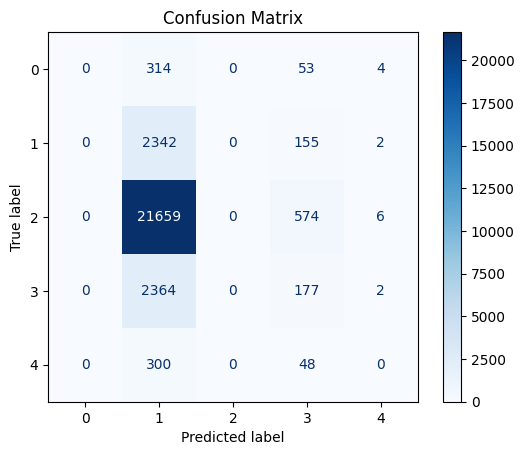

In [57]:
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()